# Bird Image Classification Project

## Imports and Data Loading

In [1]:
# Imports
from glob import glob
import math
import os
import pandas as pd
from pathlib import Path
import pickle
from PIL import Image
import random
#import tensorflow as tf
#from transformers import AutoImageProcessor, TFViTForImageClassification as ViTForImageClassification

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Define path to data directory
#data_dir = os.path.join('drive', 'MyDrive', 'ConcordiaBootcamp', 'Data', 'birds')
data_dir = 'data'

## EDA

In [3]:
# Get subfolders
subfolders = [d.name for d in Path(data_dir).iterdir() if d.is_dir()]
subfolders

['valid', 'test', 'train', 'images to predict']

In [5]:
# Get categories
categories = [d.name for d in Path(data_dir + '/train').iterdir() if d.is_dir()]
categories

['AFRICAN EMERALD CUCKOO',
 'AMERICAN COOT',
 'AFRICAN PYGMY GOOSE',
 'ABBOTTS BABBLER',
 'ALBERTS TOWHEE',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN FLAMINGO',
 'AMERICAN AVOCET',
 'AFRICAN PIED HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AFRICAN OYSTER CATCHER',
 'ALPINE CHOUGH',
 'AMERICAN BITTERN',
 'ABYSSINIAN GROUND HORNBILL',
 'ALBATROSS',
 'ABBOTTS BOOBY',
 'AFRICAN FIREFINCH',
 'ALEXANDRINE PARAKEET']

In [6]:
# Get total number of images
complete_list = list(Path(data_dir).glob('*/*/*.jpg'))
nb_images = len(complete_list)
nb_images

3408

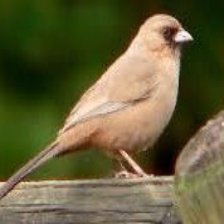

In [7]:
# Load one image at random
img_path = random.choice(complete_list)
image = Image.open(img_path)
display(image)

## Data Preprocessing

In [8]:
# Add images into a dataframe
birds = []

for subfolder in subfolders:
  subfolder_path = os.path.join(data_dir, subfolder)
  categories = [d.name for d in Path(subfolder_path).iterdir() if d.is_dir()]
  categories = sorted(categories)

  if len(categories) > 0: # remove images to predict

    for i, category in enumerate(categories):
      category_path = os.path.join(subfolder_path, category)
      img_path_list = list(Path(category_path).glob('*.jpg'))

      for img_path in img_path_list:
        img = Image.open(img_path)
        width, height = img.size
        birds.append({
            'set': subfolder,
            'image': img,
            'width': width,
            'height': height,
            'number': i,
            'label': category
        })

birds_df = pd.DataFrame(birds)
birds_df.sample(5)

,set,image,width,height,number,label
159,test,<PIL.JpegImagePlugin.JpegImageFile image mode=...,224,224,11,ALEXANDRINE PARAKEET
625,train,<PIL.JpegImagePlugin.JpegImageFile image mode=...,224,224,2,ABYSSINIAN GROUND HORNBILL
967,train,<PIL.JpegImagePlugin.JpegImageFile image mode=...,224,224,4,AFRICAN EMERALD CUCKOO
1686,train,<PIL.JpegImagePlugin.JpegImageFile image mode=...,224,224,9,ALBATROSS
1643,train,<PIL.JpegImagePlugin.JpegImageFile image mode=...,224,224,8,AFRICAN PYGMY GOOSE


In [9]:
# Serialize data with pickle
with open('birds.pkl', 'wb') as handle:
  pickle.dump(birds_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

---

In [10]:
# Load dataframe
with open('birds.pkl', 'rb') as handle:
	birds_df = pickle.load(handle)
birds_df.head(5)

,set,image,width,height,number,label
0,valid,<PIL.JpegImagePlugin.JpegImageFile image mode=...,224,224,0,ABBOTTS BABBLER
1,valid,<PIL.JpegImagePlugin.JpegImageFile image mode=...,224,224,0,ABBOTTS BABBLER
2,valid,<PIL.JpegImagePlugin.JpegImageFile image mode=...,224,224,0,ABBOTTS BABBLER
3,valid,<PIL.JpegImagePlugin.JpegImageFile image mode=...,224,224,0,ABBOTTS BABBLER
4,valid,<PIL.JpegImagePlugin.JpegImageFile image mode=...,224,224,0,ABBOTTS BABBLER


In [13]:
birds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3408 entries, 0 to 3407
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   set     3408 non-null   object
 1   image   3408 non-null   object
 2   width   3408 non-null   int64 
 3   height  3408 non-null   int64 
 4   number  3408 non-null   int64 
 5   label   3408 non-null   object
dtypes: int64(3), object(3)
memory usage: 159.9+ KB


In [17]:
# Create number to category map
numbers = birds_df['number'].sort_values().unique()
labels = birds_df['label'].sort_values().unique()

category_map = pd.Series(labels, index=numbers).to_dict()
category_map

{0: 'ABBOTTS BABBLER',
 1: 'ABBOTTS BOOBY',
 2: 'ABYSSINIAN GROUND HORNBILL',
 3: 'AFRICAN CROWNED CRANE',
 4: 'AFRICAN EMERALD CUCKOO',
 5: 'AFRICAN FIREFINCH',
 6: 'AFRICAN OYSTER CATCHER',
 7: 'AFRICAN PIED HORNBILL',
 8: 'AFRICAN PYGMY GOOSE',
 9: 'ALBATROSS',
 10: 'ALBERTS TOWHEE',
 11: 'ALEXANDRINE PARAKEET',
 12: 'ALPINE CHOUGH',
 13: 'ALTAMIRA YELLOWTHROAT',
 14: 'AMERICAN AVOCET',
 15: 'AMERICAN BITTERN',
 16: 'AMERICAN COOT',
 17: 'AMERICAN FLAMINGO',
 18: 'AMERICAN GOLDFINCH',
 19: 'AMERICAN KESTREL'}

In [ ]:
# Define dimensions for image generator
width = math.floor(birds_df['width'].mean())
height = math.floor(birds_df['height'].mean())

(width, height)

(224, 224)

## Data Modeling

### Load Pretrained Model

In [19]:
# Get pre-trained model
checkpoint = 'google/vit-base-patch16-224'

In [20]:
feature_extractor = ViTImageProcessor.from_pretrained(checkpoint)

In [14]:
# pip install huggingface_hub[hf_xet]

In [21]:
model = ViTForImageClassification.from_pretrained(checkpoint)

All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


## Evaluate Model

## Fine-tuning

## Make predictions

In [ ]:
inputs = feature_extractor(images=image, return_tensors="tf")

In [ ]:
outputs = model(**inputs)

In [ ]:
logits = outputs.logits
logits

<tf.Tensor: shape=(1, 1000), dtype=float32, numpy=
array([[-9.04861912e-02,  4.56755430e-01, -1.74099529e+00,
        -7.55263150e-01, -1.53313720e+00, -1.62584275e-01,
        -5.63834548e-01,  1.66435406e-01,  1.73717988e+00,
         1.07816890e-01,  7.72929001e+00,  2.35874677e+00,
         4.12388706e+00,  6.46748877e+00,  2.51989484e+00,
         2.50273299e+00,  6.62427950e+00,  4.09336853e+00,
         3.60902023e+00,  6.80125427e+00,  6.74532652e+00,
         7.29744211e-02, -6.67990327e-01, -8.78206611e-01,
         2.18577504e-01,  1.00066113e+00,  7.81633854e-01,
         4.76002842e-02,  6.46305323e-01,  3.84979814e-01,
         3.05086911e-01, -7.18524158e-01, -2.55222559e-01,
        -6.25869274e-01,  4.57130104e-01,  1.74121881e+00,
         1.31881320e+00,  1.47069085e+00,  4.32786494e-01,
        -8.24516565e-02,  8.41559023e-02,  1.65074325e+00,
         2.94527590e-01,  4.80868489e-01,  1.69106758e+00,
         1.37743545e+00, -2.88802564e-01,  1.32710910e+00,
     

In [ ]:
predicted_class_idx = logits.numpy().argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: brambling, Fringilla montifringilla


## End